In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
#psi4.core.set_output_file('output.dat', False)
import time
from scipy.optimize import curve_fit


In [3]:
min_length = 1.0  # Minimum bond length
max_length = 2.2  # Maximum bond length

# Define the equilibrium bond length
equilibrium_length = 1.5500000000000003  # Adjust as needed

# Specify the number of data points you want near the equilibrium bond length
num_points_near_equilibrium = 25

# Specify the number of data points in the remaining range
num_points_remaining = 25

# Create a non-uniform grid
grid_near_equilibrium = np.linspace(equilibrium_length - 0.5, equilibrium_length + 0.5, num_points_near_equilibrium)
grid_remaining = np.linspace(min_length, max_length, num_points_remaining)

# Combine the grids to create the non-uniform grid
r_array = np.sort(np.concatenate((grid_near_equilibrium, grid_remaining)))
#print(r_array)

In [4]:
# setup basic arguments for qed-ci calculation

# z-matrix for LIH
mol_str = """
Li
H 1 1.8
symmetry c1
"""

# options for Psi4
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}



In [5]:
# template for the z-matrix so we can scan through bond lengths
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""


# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

#r_array = np.linspace(1.0, 4.0, N_R)


# array for energies for LiH outside cavity
cavity_free_E_array = np.zeros((N_R, N_el))

# array  for energies inside the cavity
cavity_E_array = np.zeros((N_R, N_el))

r_idx = 0
for r in r_array:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    print(mol_str)
    
    # call psi4 RHF
    scf_e, wfn = psi4.energy('SCF/sto-3g', return_wfn=True)
    
    # call psi4 FCI
    fci_energy = psi4.energy('fci/sto-3g',ref_wfn=wfn)
    
    # LiH no cavity
    LiH = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(LiH.CIeigs[0], fci_energy)
    
    # LiH with cavity
    LiH_cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_free_E_array[r_idx,:] = LiH.CIeigs[:N_el]
    cavity_E_array[r_idx,:] = LiH_cav.CIeigs[:N_el]
    r_idx += 1





Li
H 1 1.0
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:22 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ------------------------------------

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3092409411E-01.
  Reciprocal condition number of the overlap matrix is 1.2400502257E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7134337425231934 seconds

Li
H 1 1.05
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:24 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,  

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.50979393468973   -7.50979e+00   0.00000e+00 
   @RHF iter   1:    -7.78135544464456   -2.71562e-01   1.41409e-02 DIIS/ADIIS
   @RHF iter   2:    -7.78997852394855   -8.62308e-03   1.42322e-03 DIIS/ADIIS
   @RHF iter   3:    -7.79013984841200   -1.61324e-04   4.25557e-04 DIIS/ADIIS
   @RHF iter   4:    -7.79017315718951   -3.33088e-05   1.05633e-04 DIIS/ADIIS
   @RHF iter   5:    -7.79017529542065   -2.13823e-06   8.98471e-07 DIIS
   @RHF iter   6:    -7.79017529557982   -1.59167e-10   2.33203e-08 DIIS
   @RHF iter   7:    -7.79017529557984   -2.30926e-14   5.37469e-10 DIIS
   @

 Completed Hamiltonian build in 0.7031090259552002 seconds

Li
H 1 1.0500000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:25 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3578172766E-01.
  Reciprocal condition number of the overlap matrix is 1.2751140645E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6905949115753174 seconds

Li
H 1 1.091666666666667
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:27 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.4048973456E-01.
  Reciprocal condition number of the overlap matrix is 1.3084206029E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7151191234588623 seconds

Li
H 1 1.1
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:29 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.4150658573E-01.
  Reciprocal condition number of the overlap matrix is 1.3155553011E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.709266185760498 seconds

Li
H 1 1.1333333333333335
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:31 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.4583078693E-01.
  Reciprocal condition number of the overlap matrix is 1.3457332391E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7104849815368652 seconds

Li
H 1 1.15
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:32 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,  

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.4814858918E-01.
  Reciprocal condition number of the overlap matrix is 1.3618269161E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7259418964385986 seconds

Li
H 1 1.1750000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:34 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.5182144268E-01.
  Reciprocal condition number of the overlap matrix is 1.3872518484E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6836278438568115 seconds

Li
H 1 1.2
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:36 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.5573001124E-01.
  Reciprocal condition number of the overlap matrix is 1.4142418333E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.682852029800415 seconds

Li
H 1 1.216666666666667
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:38 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

   @RHF iter   8:    -7.83898306243549    6.21725e-15   1.00081e-11 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.349180     2A     -0.312257  

    Virtual:                                                              

       3A      0.079504     4A      0.161656     5A      0.161656  
       6A      0.621083  

    Final Occupation by Irrep:
              A 
    DOCC [     2 ]
    NA   [     2 ]
    NB   [     2 ]

  @RHF Final Energy:    -7.83898306243549

   => Energetics <=

    Nuclear Repulsion Energy =              1.3048205194602731
    One-Electron Energy =                 -12.9647345121438899
    Two-Electron Energy =                   3.8209309302481254
    Total Energy =                         -7.8389830624354913

Computation Completed


Properties will be evaluated at   0.000000,   0.000000,   0.00000

 Completed Hamiltonian build in 0.6949079036712646 seconds

Li
H 1 1.25
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:39 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,  

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.48011406374476   -7.48011e+00   0.00000e+00 
   @RHF iter   1:    -7.83269654248182   -3.52582e-01   1.62568e-02 DIIS/ADIIS
   @RHF iter   2:    -7.84461149728552   -1.19150e-02   1.70363e-03 DIIS/ADIIS
   @RHF iter   3:    -7.84485670284337   -2.45206e-04   5.02269e-04 DIIS/ADIIS
   @RHF iter   4:    -7.84490504903201   -4.83462e-05   4.15462e-05 DIIS
   @RHF iter   5:    -7.84490531545752   -2.66426e-07   1.34870e-06 DIIS
   @RHF iter   6:    -7.84490531566978   -2.12261e-10   9.38928e-09 DIIS
   @RHF iter   7:    -7.84490531566979   -3.55271e-15   9.00066e-10 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7112760543823242 seconds

Li
H 1 1.2583333333333335
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:41 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.47915223056217   -7.47915e+00   0.00000e+00 
   @RHF iter   1:    -7.83388383983503   -3.54732e-01   1.63301e-02 DIIS/ADIIS
   @RHF iter   2:    -7.84592926568144   -1.20454e-02   1.71195e-03 DIIS/ADIIS
   @RHF iter   3:    -7.84617743566963   -2.48170e-04   5.04625e-04 DIIS/ADIIS
   @RHF iter   4:    -7.84622628538753   -4.88497e-05   3.92947e-05 DIIS
   @RHF iter   5:    -7.84622652071140   -2.35324e-07   1.36142e-06 DIIS
   @RHF iter   6:    -7.84622652092025   -2.08849e-10   9.00451e-09 DIIS
   @RHF iter   7:    -7.84622652092027   -1.68754e-14   9.02582e-10 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7090141773223877 seconds

Li
H 1 1.3
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:43 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.7368726521E-01.
  Reciprocal condition number of the overlap matrix is 1.5381658271E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7614030838012695 seconds

Li
H 1 1.3000000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:45 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C_inf_v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----

 Completed Hamiltonian build in 0.7304651737213135 seconds

Li
H 1 1.3416666666666668
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:46 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.8222723109E-01.
  Reciprocal condition number of the overlap matrix is 1.5973879060E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7159128189086914 seconds

Li
H 1 1.35
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:48 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,  

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.8400637088E-01.
  Reciprocal condition number of the overlap matrix is 1.6097651184E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7140541076660156 seconds

Li
H 1 1.3833333333333335
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:50 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.9135194189E-01.
  Reciprocal condition number of the overlap matrix is 1.6610351180E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.71897292137146 seconds

Li
H 1 1.4000000000000001
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:52 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.46507682744786   -7.46508e+00   0.00000e+00 
   @RHF iter   1:    -7.84589357684296   -3.80817e-01   1.74461e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86019017808193   -1.42966e-02   1.81193e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86048169917872   -2.91521e-04   5.39725e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86053860949657   -5.69103e-05   1.92556e-05 DIIS
   @RHF iter   5:    -7.86053866105443   -5.15579e-08   4.04028e-07 DIIS
   @RHF iter   6:    -7.86053866105704   -2.61391e-12   9.82293e-09 DIIS
   @RHF iter   7:    -7.86053866105704   -8.88178e-16   1.29287e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7140376567840576 seconds

Li
H 1 1.4250000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:54 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.0102892261E-01.
  Reciprocal condition number of the overlap matrix is 1.7290392486E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7056419849395752 seconds

Li
H 1 1.4500000000000002
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:55 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.46092746887021   -7.46093e+00   0.00000e+00 
   @RHF iter   1:    -7.84707682698562   -3.86149e-01   1.77938e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86220465625288   -1.51278e-02   1.82819e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86250799258441   -3.03336e-04   5.50641e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86256772200250   -5.97294e-05   2.17428e-05 DIIS
   @RHF iter   5:    -7.86256778552577   -6.35233e-08   6.60981e-07 DIIS
   @RHF iter   6:    -7.86256778556107   -3.53042e-11   1.38057e-08 DIIS
   @RHF iter   7:    -7.86256778556107   -1.77636e-15   1.25324e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7141151428222656 seconds

Li
H 1 1.4666666666666668
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:57 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45961892613260   -7.45962e+00   0.00000e+00 
   @RHF iter   1:    -7.84718095597989   -3.87562e-01   1.79057e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86259242768825   -1.54115e-02   1.83135e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86289925313301   -3.06825e-04   5.54177e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86295993319273   -6.06801e-05   2.35190e-05 DIIS
   @RHF iter   5:    -7.86296000674354   -7.35508e-08   8.97455e-07 DIIS
   @RHF iter   6:    -7.86296000681574   -7.22009e-11   1.62635e-08 DIIS
   @RHF iter   7:    -7.86296000681576   -2.04281e-14   1.38581e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7095379829406738 seconds

Li
H 1 1.5
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:05:59 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45710254077439   -7.45710e+00   0.00000e+00 
   @RHF iter   1:    -7.84699172250967   -3.89889e-01   1.81245e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86298182190882   -1.59901e-02   1.83426e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86329491532613   -3.13093e-04   5.61129e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86335751677862   -6.26015e-05   2.81233e-05 DIIS
   @RHF iter   5:    -7.86335762137111   -1.04592e-07   1.29333e-06 DIIS
   @RHF iter   6:    -7.86335762153831   -1.67197e-10   2.03392e-08 DIIS
   @RHF iter   7:    -7.86335762153832   -1.42109e-14   1.62181e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7127680778503418 seconds

Li
H 1 1.5083333333333335
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:01 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.2189200272E-01.
  Reciprocal condition number of the overlap matrix is 1.8777210072E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7097620964050293 seconds

Li
H 1 1.5500000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:02 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45355629906325   -7.45356e+00   0.00000e+00 
   @RHF iter   1:    -7.84579883145281   -3.92243e-01   1.84424e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86268880894229   -1.68900e-02   1.83001e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86300943765907   -3.20629e-04   5.71323e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86307497527861   -6.55376e-05   3.69705e-05 DIIS
   @RHF iter   5:    -7.86307516097855   -1.85700e-07   1.68943e-06 DIIS
   @RHF iter   6:    -7.86307516129280   -3.14250e-10   2.62816e-08 DIIS
   @RHF iter   7:    -7.86307516129281   -1.86517e-14   2.03480e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7049670219421387 seconds

Li
H 1 1.5500000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:04 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45355629906325   -7.45356e+00   0.00000e+00 
   @RHF iter   1:    -7.84579883145281   -3.92243e-01   1.84424e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86268880894229   -1.68900e-02   1.83001e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86300943765907   -3.20629e-04   5.71323e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86307497527861   -6.55376e-05   3.69705e-05 DIIS
   @RHF iter   5:    -7.86307516097855   -1.85700e-07   1.68943e-06 DIIS
   @RHF iter   6:    -7.86307516129280   -3.14250e-10   2.62816e-08 DIIS
   @RHF iter   7:    -7.86307516129281   -1.86517e-14   2.03480e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.715770959854126 seconds

Li
H 1 1.5916666666666668
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:06 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.4449755137E-01.
  Reciprocal condition number of the overlap matrix is 2.0424377728E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.70589280128479 seconds

Li
H 1 1.6
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:08 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    5

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45025279506637   -7.45025e+00   0.00000e+00 
   @RHF iter   1:    -7.84363637586890   -3.93384e-01   1.87511e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86147012479242   -1.78337e-02   1.81535e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86179590986131   -3.25785e-04   5.81312e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86186444903221   -6.85392e-05   4.74228e-05 DIIS
   @RHF iter   5:    -7.86186476934021   -3.20308e-07   1.93130e-06 DIIS
   @RHF iter   6:    -7.86186476978394   -4.43729e-10   3.21691e-08 DIIS
   @RHF iter   7:    -7.86186476978399   -4.61853e-14   2.52183e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7170121669769287 seconds

Li
H 1 1.6333333333333335
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:09 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.5634748463E-01.
  Reciprocal condition number of the overlap matrix is 2.1304243282E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7148401737213135 seconds

Li
H 1 1.6500000000000001
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:11 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.6117583319E-01.
  Reciprocal condition number of the overlap matrix is 2.1666147994E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.703930139541626 seconds

Li
H 1 1.6750000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:13 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.44569327636337   -7.44569e+00   0.00000e+00 
   @RHF iter   1:    -7.83883110330751   -3.93138e-01   1.92042e-02 DIIS/ADIIS
   @RHF iter   2:    -7.85817622493801   -1.93451e-02   1.77394e-03 DIIS/ADIIS
   @RHF iter   3:    -7.85850499631613   -3.28771e-04   5.96022e-04 DIIS/ADIIS
   @RHF iter   4:    -7.85857814822926   -7.31519e-05   6.50520e-05 DIIS
   @RHF iter   5:    -7.85857879778793   -6.49559e-07   2.13318e-06 DIIS
   @RHF iter   6:    -7.85857879839139   -6.03463e-10   4.04493e-08 DIIS
   @RHF iter   7:    -7.85857879839148   -9.32587e-14   3.31645e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7061059474945068 seconds

Li
H 1 1.7000000000000002
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:15 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.7592776733E-01.
  Reciprocal condition number of the overlap matrix is 2.2784458221E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7051458358764648 seconds

Li
H 1 1.7166666666666668
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:16 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.44334321024763   -7.44334e+00   0.00000e+00 
   @RHF iter   1:    -7.83545982894764   -3.92117e-01   1.94540e-02 DIIS/ADIIS
   @RHF iter   2:    -7.85570080931320   -2.02410e-02   1.74110e-03 DIIS/ADIIS
   @RHF iter   3:    -7.85602868436501   -3.27875e-04   6.04069e-04 DIIS/ADIIS
   @RHF iter   4:    -7.85610444438860   -7.57600e-05   7.55228e-05 DIIS
   @RHF iter   5:    -7.85610535386130   -9.09473e-07   2.18979e-06 DIIS
   @RHF iter   6:    -7.85610535453539   -6.74090e-10   4.45138e-08 DIIS
   @RHF iter   7:    -7.85610535453552   -1.32339e-13   3.75039e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7161290645599365 seconds

Li
H 1 1.75
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:18 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,  

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.9102217732E-01.
  Reciprocal condition number of the overlap matrix is 2.3949029724E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7195098400115967 seconds

Li
H 1 1.7583333333333335
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:20 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.44111235264421   -7.44111e+00   0.00000e+00 
   @RHF iter   1:    -7.83165028259287   -3.90538e-01   1.97044e-02 DIIS/ADIIS
   @RHF iter   2:    -7.85283174407627   -2.11815e-02   1.70160e-03 DIIS/ADIIS
   @RHF iter   3:    -7.85315688274975   -3.25139e-04   6.12015e-04 DIIS/ADIIS
   @RHF iter   4:    -7.85323527150321   -7.83888e-05   8.63197e-05 DIIS
   @RHF iter   5:    -7.85323650176538   -1.23026e-06   2.21369e-06 DIIS
   @RHF iter   6:    -7.85323650249408   -7.28704e-10   4.79930e-08 DIIS
   @RHF iter   7:    -7.85323650249424   -1.61648e-13   4.14853e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7137479782104492 seconds

Li
H 1 1.8000000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:22 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.43899364259102   -7.43899e+00   0.00000e+00 
   @RHF iter   1:    -7.82744533231194   -3.88452e-01   1.99564e-02 DIIS/ADIIS
   @RHF iter   2:    -7.84961545306892   -2.21701e-02   1.65597e-03 DIIS/ADIIS
   @RHF iter   3:    -7.84993605538991   -3.20602e-04   6.19837e-04 DIIS/ADIIS
   @RHF iter   4:    -7.85001708079200   -8.10254e-05   9.73534e-05 DIIS
   @RHF iter   5:    -7.85001869633519   -1.61554e-06   2.20510e-06 DIIS
   @RHF iter   6:    -7.85001869709765   -7.62469e-10   5.06870e-08 DIIS
   @RHF iter   7:    -7.85001869709786   -2.06057e-13   4.48244e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.705955982208252 seconds

Li
H 1 1.8000000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:23 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.43899364259102   -7.43899e+00   0.00000e+00 
   @RHF iter   1:    -7.82744533231194   -3.88452e-01   1.99564e-02 DIIS/ADIIS
   @RHF iter   2:    -7.84961545306892   -2.21701e-02   1.65597e-03 DIIS/ADIIS
   @RHF iter   3:    -7.84993605538991   -3.20602e-04   6.19837e-04 DIIS/ADIIS
   @RHF iter   4:    -7.85001708079200   -8.10254e-05   9.73534e-05 DIIS
   @RHF iter   5:    -7.85001869633519   -1.61554e-06   2.20510e-06 DIIS
   @RHF iter   6:    -7.85001869709765   -7.62469e-10   5.06870e-08 DIIS
   @RHF iter   7:    -7.85001869709786   -2.06057e-13   4.48244e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7109408378601074 seconds

Li
H 1 1.8416666666666668
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:25 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.1934286338E-01.
  Reciprocal condition number of the overlap matrix is 2.6192310122E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7171289920806885 seconds

Li
H 1 1.85
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:27 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,  

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.43659110149876   -7.43659e+00   0.00000e+00 
   @RHF iter   1:    -7.82193052979616   -3.85339e-01   2.02626e-02 DIIS/ADIIS
   @RHF iter   2:    -7.84535567173727   -2.34251e-02   1.59432e-03 DIIS/ADIIS
   @RHF iter   3:    -7.84566859724267   -3.12926e-04   6.29010e-04 DIIS/ADIIS
   @RHF iter   4:    -7.84575277436306   -8.41771e-05   1.10810e-04 DIIS/ADIIS
   @RHF iter   5:    -7.84575494145527   -2.16709e-06   2.11370e-06 DIIS
   @RHF iter   6:    -7.84575494219193   -7.36661e-10   5.21158e-08 DIIS
   @RHF iter   7:    -7.84575494219217   -2.38032e-13   4.65563e-09 DIIS
   @

 Completed Hamiltonian build in 0.7097299098968506 seconds

Li
H 1 1.8833333333333335
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:29 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.43507032656957   -7.43507e+00   0.00000e+00 
   @RHF iter   1:    -7.81799647712841   -3.82926e-01   2.04697e-02 DIIS/ADIIS
   @RHF iter   2:    -7.84230276206832   -2.43063e-02   1.55008e-03 DIIS/ADIIS
   @RHF iter   3:    -7.84260935657012   -3.06595e-04   6.34958e-04 DIIS/ADIIS
   @RHF iter   4:    -7.84269561147115   -8.62549e-05   1.19870e-04 DIIS/ADIIS
   @RHF iter   5:    -7.84269820214457   -2.59067e-06   2.01121e-06 DIIS
   @RHF iter   6:    -7.84269820283080   -6.86226e-10   5.18807e-08 DIIS
   @RHF iter   7:    -7.84269820283105   -2.47802e-13   4.63417e-09 DIIS
   @

 Completed Hamiltonian build in 0.7132022380828857 seconds

Li
H 1 1.9000000000000001
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:31 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.3763717063E-01.
  Reciprocal condition number of the overlap matrix is 2.7683862530E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7150051593780518 seconds

Li
H 1 1.9250000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:32 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.43325664393025   -7.43326e+00   0.00000e+00 
   @RHF iter   1:    -7.81281565407001   -3.79559e-01   2.07325e-02 DIIS/ADIIS
   @RHF iter   2:    -7.83827660635622   -2.54610e-02   1.49300e-03 DIIS/ADIIS
   @RHF iter   3:    -7.83857416374013   -2.97557e-04   6.42151e-04 DIIS/ADIIS
   @RHF iter   4:    -7.83866296767511   -8.88039e-05   1.31257e-04 DIIS/ADIIS
   @RHF iter   5:    -7.83866615228109   -3.18461e-06   1.83395e-06 DIIS
   @RHF iter   6:    -7.83866615286853   -5.87447e-10   5.00284e-08 DIIS
   @RHF iter   7:    -7.83866615286878   -2.46914e-13   4.42253e-09 DIIS
   @

 Completed Hamiltonian build in 0.727553129196167 seconds

Li
H 1 1.9500000000000002
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:34 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.5338907281E-01.
  Reciprocal condition number of the overlap matrix is 2.8996128093E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7097189426422119 seconds

Li
H 1 1.9666666666666668
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:36 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.5864234284E-01.
  Reciprocal condition number of the overlap matrix is 2.9439700104E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7198169231414795 seconds

Li
H 1 2.0
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:38 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.6913900640E-01.
  Reciprocal condition number of the overlap matrix is 3.0335102550E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7074112892150879 seconds

Li
H 1 2.0083333333333337
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:40 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.7175947637E-01.
  Reciprocal condition number of the overlap matrix is 3.0560553784E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7158248424530029 seconds

Li
H 1 2.0500000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:41 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.8482594659E-01.
  Reciprocal condition number of the overlap matrix is 3.1696367320E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7026021480560303 seconds

Li
H 1 2.0500000000000003
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:43 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.8482594659E-01.
  Reciprocal condition number of the overlap matrix is 3.1696367320E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7211799621582031 seconds

Li
H 1 2.1000000000000005
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:45 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.0039178984E-01.
  Reciprocal condition number of the overlap matrix is 3.3075341220E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7245309352874756 seconds

Li
H 1 2.1500000000000004
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:47 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.1578134068E-01.
  Reciprocal condition number of the overlap matrix is 3.4467280713E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7052929401397705 seconds

Li
H 1 2.2
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:06:48 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.42348424947293   -7.42348e+00   0.00000e+00 
   @RHF iter   1:    -7.77283133511380   -3.49347e-01   2.25945e-02 DIIS/ADIIS
   @RHF iter   2:    -7.80763267765833   -3.48013e-02   1.40202e-03 DIIS/ADIIS
   @RHF iter   3:    -7.80788391119046   -2.51234e-04   6.76427e-04 DIIS/ADIIS
   @RHF iter   4:    -7.80798541219512   -1.01501e-04   2.06353e-04 DIIS/ADIIS
   @RHF iter   5:    -7.80799436797528   -8.95578e-06   2.19438e-06 DIIS
   @RHF iter   6:    -7.80799436914781   -1.17253e-09   5.05674e-08 DIIS
   @RHF iter   7:    -7.80799436914808   -2.71783e-13   8.42816e-09 DIIS
   @

 Completed Hamiltonian build in 0.7111458778381348 seconds


In [6]:
# z-matrix for LIH
mol_str = """
Li
H 1 1.8
symmetry c1
"""

# options dictionary for the psi4 calculation
options_dict0 = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# let's run a psi4 geometry optimization to get the optimal geometry

# set the options
psi4.set_options(options_dict0)

# first set the coordinates in init_string as the molecule's geometry 
mol0 = psi4.geometry(mol_str)

# now capture the psi4 geometry data with the guess coordinates
init_geometry_string = psi4.core.Molecule.create_psi4_string_from_molecule(mol0)

# run the geometry optimization
psi4.optimize("HF")

guess_geometry = mol0.geometry()

guess_string = psi4.core.Molecule.create_psi4_string_from_molecule(mol0)


	Change in internal coordinate of 5.69e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.



Scratch directory: /tmp/
gradient() will perform analytic gradient computation.
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:08:38 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ------

	Change in internal coordinate of 5.46e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.


   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:08:39 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Mole

	----------------------------------------------------------------------------------------------
	  Convergence Criteria     1.00e-06 *    3.00e-04 *             o    1.20e-03 *             o
	----------------------------------------------------------------------------------------------
	     4      -7.86338209   -2.94e-05      9.15e-05 *    9.15e-05 o    8.16e-04 *    8.16e-04 o  ~
	----------------------------------------------------------------------------------------------

Next Geometry in Ang 
	Fragment 1 (Ang)

	   Li   0.0000000000   0.0000000000  -0.1896004272
	    H   0.0000000000   0.0000000000   1.3211957834


    Final optimized geometry and variables:
    Molecular point group: c1
    Full point group: C_inf_v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

    LI      
    H             1    1.511228



In [7]:
# options dictionary for the psi4 calculation
options_dict = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# set the options
psi4.set_options(options_dict)

# first set the coordinates in guess_string as the molecule's geometry 
mol = psi4.geometry(guess_string)

# now capture the psi4 geometry data with the guess coordinates
guess_geometry_string = psi4.core.Molecule.create_psi4_string_from_molecule(mol)

# run the geometry optimization
psi4.optimize("HF")

opt_geometry = mol.geometry()

# capture the psi4 geometry data from the optimization
opt_geometry_string = psi4.core.Molecule.create_psi4_string_from_molecule(mol)

# run excited-state calculations - get first 5 excited states
n_states = 1

# run psi4 TDSCF at same level of theory as geometry optimization
psi4_rhf_e, wfn = psi4.frequency("CAM-b3lyp/sto-3g", return_wfn=True, molecule=mol,maxiter=50)




Scratch directory: /tmp/
gradient() will perform analytic gradient computation.
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov  7 13:08:42 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ------


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

    T. Yanai, D. P. Tew, and N. C. Handy.,  Chem. Phys. Lett. 393, 51 (2004) (10.1016/j.cplett.2004.06.011)

    Deriv               =              1
    GGA                 =           TRUE
    Meta                =          FALSE

    Exchange Hybrid     =           TRUE
    MP2 Hybrid          =          FALSE

   => Exchange Functionals <=

    0.3500         Becke 88 [omega = 0.3300]
    0.4600   Short-range recipe for B88 functional - erf [omega = 0.3300]

   => Exact (HF) Exchange <=

    0.4600            HF,LR [omega = 0.3300]
    0.1900               HF 

   => Correlation Functionals <=

    0.1900   Vosko, Wilk & Nusair (VWN5)
    0.8100   Lee, Yang & Parr

   => LibXC Density Thresholds  <==

    XC_HYB_GGA_XC_CAM_B3LYP:  1.00E-14 

   => Molecular Quadrature <=

    Radial Scheme          =       TREUTLER
    Pruning Scheme         =           NONE
    Nuclear Scheme         =       TREUTLER

    Blocking Scheme        =         OCTREE
    BS radius alpha        =        


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

    Psi4 stopped on: Tuesday, 07 November 2023 01:08PM
    Psi4 wall time for execution: 0:00:00.36


  //>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>//
  //      FiniteDifference Results     //
  //<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<//

  Computing second-derivative from gradients using projected, 
  symmetry-adapted, cartesian coordinates.

  7 gradients passed in, including the reference geometry.
  Generating complete list of displacements from unique ones.


-------------------------------------------------------------


  ==> Harmonic Vibrational Analysis <==

  non-mass-weighted Hessian:       Symmetric? True   Hermitian? True   Lin Dep Dim?  3 (0)
  projection of translations (True) and rotations (True) removed 5 degrees of freedom (5)
  total projector:                 Symmetric? True   Hermitian? True   Lin Dep Dim?  5 (5)
  mass-weighted Hessian:           Symmetric? True   Hermitian? True   Lin Dep Dim?  3 (0)
  pre-proj  low-frequency mode:    0.0000i [cm^-1]
  pre-proj  low-freque

In [8]:
from matplotlib import pyplot as plt
from scipy import interpolate

## Calculation of the Huang-Rhys Factor
Huang Rhys factor can be calculated by both

$$ S = 1/2(\Delta x / x_0)^2 \tag{Turner}$$

from the mode anharmonicity paper

and 

$$ S = \frac{m\omega_{vib} \Delta x^2}{2 \hbar} \tag{Hsu}$$

from the polaritonic Huang-Rhys factor paper

In [9]:
# Constants and Variables
x_0 = wfn.frequency_analysis["Xtp0"].data[5]
k_SI = wfn.frequency_analysis["k"].data[5] * 10 ** 2
min_S0_loc = np.argmin(cavity_free_E_array[:,0])
min_S1_loc = np.argmin(cavity_free_E_array[:,1])
delta_au = (r_array[min_S1_loc] - r_array[min_S0_loc]) * 1.8897
delta_m = (r_array[min_S1_loc] - r_array[min_S0_loc]) * 10 ** (-10)
mu_kg = (6.94 * 1.008 / (6.94 + 1.008)) * (10 ** (-3)) / (6.022 * 10 ** 23)
omega_vib = np.sqrt(k_SI / mu_kg)
h_bar = (6.626 * 10 ** (-34)) / (2 * np.pi)
r_eq = r_array[min_S0_loc]

# Turner
S_Turner = 0.5 * (delta_au / x_0) ** 2

# Hsu
S_Hsu = mu_kg * omega_vib * delta_m ** 2 / (2 * h_bar)

print(S_Turner)
print(S_Hsu)

12.71828273160398
11.228657183958255


In [10]:
D_e_Hartree = cavity_free_E_array[49,0] - cavity_free_E_array[min_S0_loc,0] 
D_e = 0.09848201074825358
D_e_J = D_e_Hartree * 4.3597 * 10 ** (-18)
alpha_inv_m = np.sqrt(k_SI / (2 * D_e_J))
alpha_inv_Angs = alpha_inv_m * 10 ** (-10)
kappa = 2 * D_e_Hartree * alpha_inv_Angs ** 2
g = -6 * D_e_Hartree * alpha_inv_Angs ** 3
h = 14 * D_e_Hartree * alpha_inv_Angs ** 4

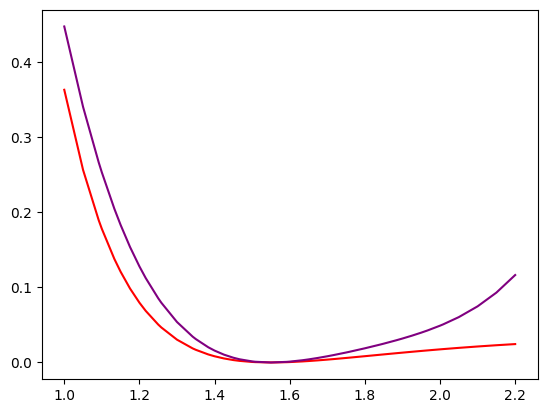

[ 0.44755014  0.34050202  0.34050202  0.26648722  0.25319933  0.20472096
  0.18313304  0.15382751  0.12796979  0.11251584  0.08555190  0.07957964
  0.05389734  0.05389734  0.03443205  0.03119975  0.02023160  0.01582842
  0.01042855  0.00632833  0.00424016  0.00142009  0.00096841  0.00000000
  0.00000000  0.00080633  0.00114002  0.00294353  0.00408776  0.00605244
  0.00826650  0.00985859  0.01327519  0.01417227  0.01888845  0.01888845
  0.02398682  0.02505653  0.02953179  0.03190539  0.03567249  0.03973661
  0.04264275  0.04902746  0.05076112  0.06043088  0.06043088  0.07477544
  0.09306541  0.11648070]


In [11]:
V_r = D_e_Hartree * (1 - np.exp(-alpha_inv_Angs * (r_array - r_eq))) ** 2

V_r_spline = interpolate.UnivariateSpline(r_array, V_r, k=4)

# now define the expansion coefficients to expand the Morse potential as a polynomial
# harmonic
f_spline = V_r_spline.derivative()
k_spline = f_spline.derivative()
g_spline = k_spline.derivative()
h_spline = g_spline.derivative()

k_num = k_spline(r_eq)
g_num = g_spline(r_eq)
h_num = h_spline(r_eq)



V_H = 1/2 * k_num * (r_array - r_eq) ** 2

# cubic
#g = -6 * D_e * alpha ** 3

V_C = V_H + 1/6 * g_num * (r_array - r_eq) ** 3

# quartic 
#h = 14 * D_e * alpha ** 4

V_Q = V_H + V_C + 1/24 * h_num * (r_array - r_eq) ** 4


plt.plot(r_array, V_r, 'red')
#plt.plot(r_array, V_r_spline(r), 'blue')
#plt.plot(r, V_C, 'green')
plt.plot(r_array, V_Q, 'purple')
#plt.xlim(0.75 * r_eq, 1.5 * r_eq)
#plt.ylim(0, 2e-18)
plt.show()
print(V_Q)

In [27]:
def quartic_morse(r, De, k, re, g, h):
    return (1 / 2) * k * (r - re) ** 2 + (1 / 6) * g * (r - re) ** 3 + (1 / 24) * h * (r - re) ** 4
    #return De * (1 - np.exp(-k * (r - re))) ** 2 + g * (r - re) ** 3 + h * (r - re) ** 4

# Initial parameter guesses
initial_guess = [D_e, kappa, r_eq, g, h]

# Perform the curve fit
fit_params, covariance = curve_fit(quartic_morse, r_array, cavity_free_E_array[:,0], p0=initial_guess, maxfev=10000)

# Extract the optimized parameters
De_fit, k_fit, re_fit, g_fit, h_fit = fit_params

V_fit = quartic_morse(r_array, De_fit, k_fit, re_fit, g_fit, h_fit)

print(V_fit)

[-7.79063386 -7.80869336 -7.80869336 -7.82205530 -7.82454851 -7.83393828
 -7.83828944 -7.84439658 -7.85001116 -7.85348681 -7.85981354 -7.86126795
 -7.86780133 -7.86780133 -7.87315063 -7.87408417 -7.87738187 -7.87877655
 -7.88056343 -7.88199785 -7.88276604 -7.88387232 -7.88406278 -7.88452908
 -7.88452908 -7.88424272 -7.88410213 -7.88328382 -7.88273036 -7.88173488
 -7.88055749 -7.87968073 -7.87773216 -7.87720854 -7.87440786 -7.87440786
 -7.87137056 -7.87074296 -7.86819089 -7.86690071 -7.86496542 -7.86304922
 -7.86179310 -7.85936149 -7.85877521 -7.85601539 -7.85601539 -7.85319365
 -7.85108390 -7.84987862]


First plot the ground-state potential energy surfaces for LiH inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

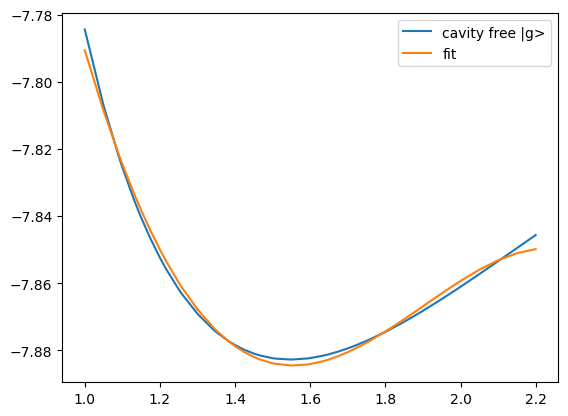

In [30]:
plt.plot(r_array, cavity_free_E_array[:,0], label='cavity free |g>')
#plt.plot(r_array, cavity_free_E_array[:,1], 'r-', label='cavity free |e>')
plt.plot(r_array, V_fit, label='fit')
plt.legend()
plt.show()


Next plot the ground state surface shifted by the cavity energy and the first excited state surface of 
LiH outside the cavity along with the lower- and upper-polariton surfaces from LiH inside the cavity.
Note that lower polariton surface intersects with another surface for the molecule in the cavity (see the crossing of the red and green curves around r = 1.5 Angstroms); the polariton surface is smooth, so we should really re-sort the eigenvalues around this point. Ruby has some experience doing this. 

In [ ]:
plt.plot(r_array, cavity_free_E_array[:,0]+0.12086, label='cavity free |g>+$\omega$')
plt.plot(r_array, cavity_free_E_array[:,1], label='cavity free |e>')
plt.plot(r_array, cavity_E_array[:,1], label='cavity |LP>')
plt.plot(r_array, cavity_E_array[:,2], label='cavity |LP>')
plt.plot(r_array, cavity_E_array[:,3], label='cavity |UP>')
plt.legend()
plt.show()